![Image of Rossmann](https://www.signavio.com/wp-content/uploads/2015/10/rossmann-logo-web.png?w=360&h=200&zc=2)

# Table of Contents

1. [Introduction](#1-bullet) <br>
2. [Importing the Libraries](#2-bullet) <br>
3. [Data Loading](#3-bullet) <br>
4. [Data cleaning and adding missing value](#4-bullet) <br>
     [4.1 Validation of Data](#4.1-bullet) <br>
5. [Analysis of different factors on Sales](#5-bullet) <br>
6. [Correlation Analysis](#6-bullet) <br>
7. [Time Series Analysis](#7-bullet) <br>
8. [Time Series Analysis using ARIMA](#8-bullet) <br>
     [8.1 Fitting ARIMA Model](#8.1-bullet) <br>
     [8.2 Forecaring with ARIMA Model](#8.2-bullet) <br>
9.[Conclusion](#9-bullet) <br>

## 1. Introduction <a class="anchor" id="1-bullet"></a>

This is a Kaggle Competition called where the task is to predict Sales products to better ensure grocery stores please customers by having just enough of the right products at the right time.

For this particular problem, We have studied the top kernels which are available on the Kaggle website and learned that they have predicted the sales of the product by applying FB prophet.

But we are trying to predict the sales by ARIMA time series analysis and comparing this model with different algorithms like Linear Regression, Random Forest, Gradient Boosting and XGBoost.

### 2. Importing the Libraries<a class="anchor" id="2-bullet"></a>

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Loading packages for data visualization,statistics,time series analysis

import pandas as pd
from pandas import DataFrame
from pandas import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as statmodel
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from pylab import rcParams
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA

### 3. Data Loading<a class="anchor" id="3-bullet"></a>

In [3]:
# Loading the data
df_store = pd.read_csv("store.csv")
df_train = pd.read_csv("train.csv", index_col='Date', parse_dates=['Date'], low_memory=False)
df_train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [4]:
df_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


Below is the short description of the Kaggle data: <br />
(1) Store - a unique Id for each store<br />
(2) Sales - the turnover for any given day (this is what you are predicting)<br />
(3) Customers - the number of customers on a given day<br />
(4) Open - an indicator for whether the store was open: 0 = closed, 1 = open<br />
(5) Promo - indicates whether a store is running a promo on that day<br />
(6) StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that                    all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c =                              Christmas, 0 = None<br />
(7) SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

### We need to extract dates for further analysis
We will take year, date and month of each date in different coloumn to analyze effect of date in a pattern.

In [5]:
df_train['Year'] = df_train.index.year
df_train['Day'] = df_train.index.day
df_train['Month'] = df_train.index.month
df_train['WeekOfYear'] = df_train.index.weekofyear

df_train['PerCustomerSale'] = df_train['Sales'] / df_train['Customers']
df_train['PerCustomerSale'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: PerCustomerSale, dtype: float64

We can conclude from above table that each customer spends about 9.4$ per day. But there are days on which sales equal to zero.

### 4. Data cleaning and adding missing values<a class="anchor" id="4-bullet"></a>

Finding out the fields in which store is open and sales value is zero. Fo that firstly we will fetch the values in which store is closed and sales  

In [6]:
dataFile = df_train[(df_train.Open == 0) & (df_train.Sales == 0)]

In [7]:
dataFile.head(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Day,Month,WeekOfYear,PerCustomerSale
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,31,7,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,31,7,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,30,7,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,30,7,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,29,7,31,NaN


Now extracting the opened stores with zero sales.

In [8]:
sale_zero = df_train [(df_train.Open != 0) & (df_train.Sales == 0)]

In [9]:
sale_zero.head(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Day,Month,WeekOfYear,PerCustomerSale
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,15,5,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,26,3,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,5,2,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,1,10,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,22,9,39,NaN


We won't consider the the values with sales as zero as well as closed store. So eliminating those values.

In [10]:
df_train = df_train[(df_train.Open!=0)&(df_train.Sales!=0)]

#### 4.1 Validating Store Data<a class="anchor" id="4.1-bullet"></a>

In [11]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We have many null values in Store data. So we have to deal with this data.

In [13]:
df_store[pd.isnull(df_store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [14]:
# Adding median value to null vales present in CompetitionDistance
df_store['CompetitionDistance'].fillna(df_store['CompetitionDistance'].median())

0        1270.0
1         570.0
2       14130.0
3         620.0
4       29910.0
5         310.0
6       24000.0
7        7520.0
8        2030.0
9        3160.0
10        960.0
11       1070.0
12        310.0
13       1300.0
14       4110.0
15       3270.0
16         50.0
17      13840.0
18       3240.0
19       2340.0
20        550.0
21       1040.0
22       4060.0
23       4590.0
24        430.0
25       2300.0
26         60.0
27       1200.0
28       2170.0
29         40.0
         ...   
1085      180.0
1086     2210.0
1087     4300.0
1088     5220.0
1089      330.0
1090     9990.0
1091      300.0
1092    10450.0
1093     2380.0
1094      690.0
1095     1130.0
1096      720.0
1097     1830.0
1098      200.0
1099      540.0
1100     4060.0
1101      850.0
1102     1340.0
1103      260.0
1104      330.0
1105     5330.0
1106     1400.0
1107      540.0
1108     3490.0
1109      900.0
1110     1900.0
1111     1880.0
1112     9260.0
1113      870.0
1114     5350.0
Name: CompetitionDistanc

In [15]:
# no promo = no information about the promo?
_ = df_store[pd.isnull(df_store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

In [16]:
df_store.fillna(0, inplace= True) #Replacing NA's in Promo2SinceWeek by zero

We will join the two data sets that is train dataset and store dataset

In [17]:
store_train = pd.merge(df_train,df_store, on = 'Store')
store_train.shape
store_train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Day,...,PerCustomerSale,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,31,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,30,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,29,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,28,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,27,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### 5. Analysis of different factors on Sales<a class="anchor" id="5-bullet"></a>

### Now analyzing the different levels of store types and how sales of store is distributed among the stores.

In [18]:
a=store_train.groupby('StoreType')['Sales']

In [19]:
a.describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


It is evedent that store B has highest average sales compared to remaining stores but this is the average value. Resulting we are printing overall sum of sales and customers for all stores.

In [20]:
store_train.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


From above table we can see that Store type A goes on First place and Store type D goes on second place. Now we will elaborate the sales using date periods.

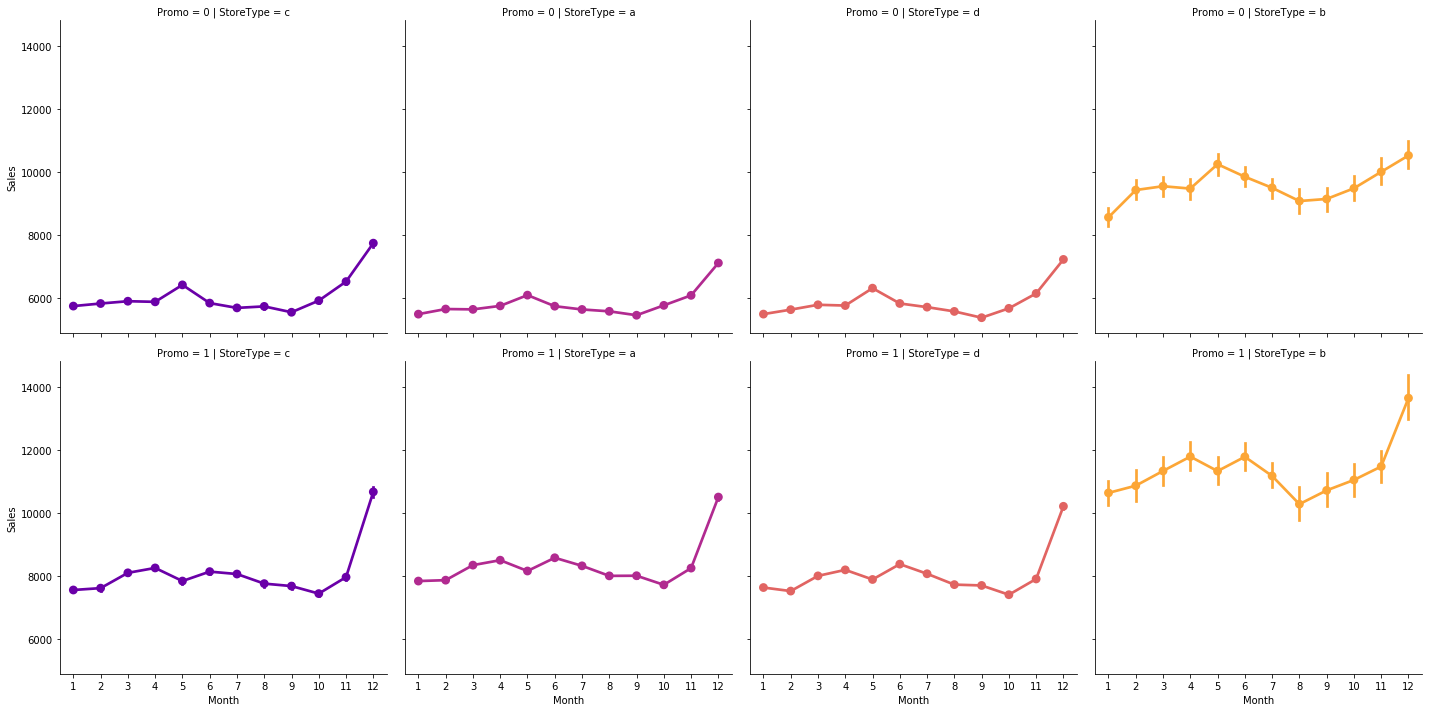

In [75]:
sns.factorplot(data = store_train, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = 'r')

All store follow the same pattern but at different scales depending on the presence of the (first) promotion Promo and  StoreType itself (case for B).

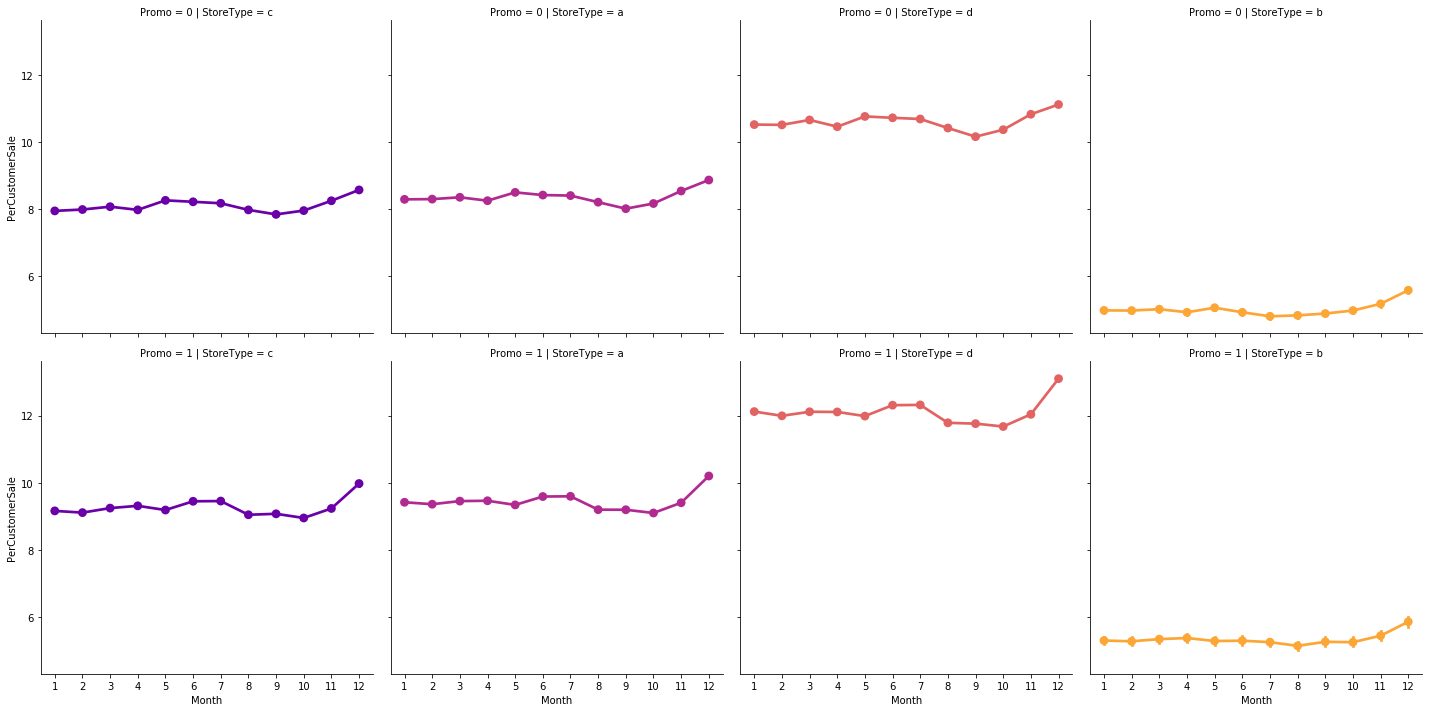

In [23]:
sns.factorplot(data = store_train, x = 'Month', y = "PerCustomerSale",col='StoreType',hue='StoreType',palette='plasma',
               row='Promo',color='r')

The plots above are explaining that Store type B is the most product selling store but reality is something else. We can see that the highest SalesPerCustomer is observed for Store type D.

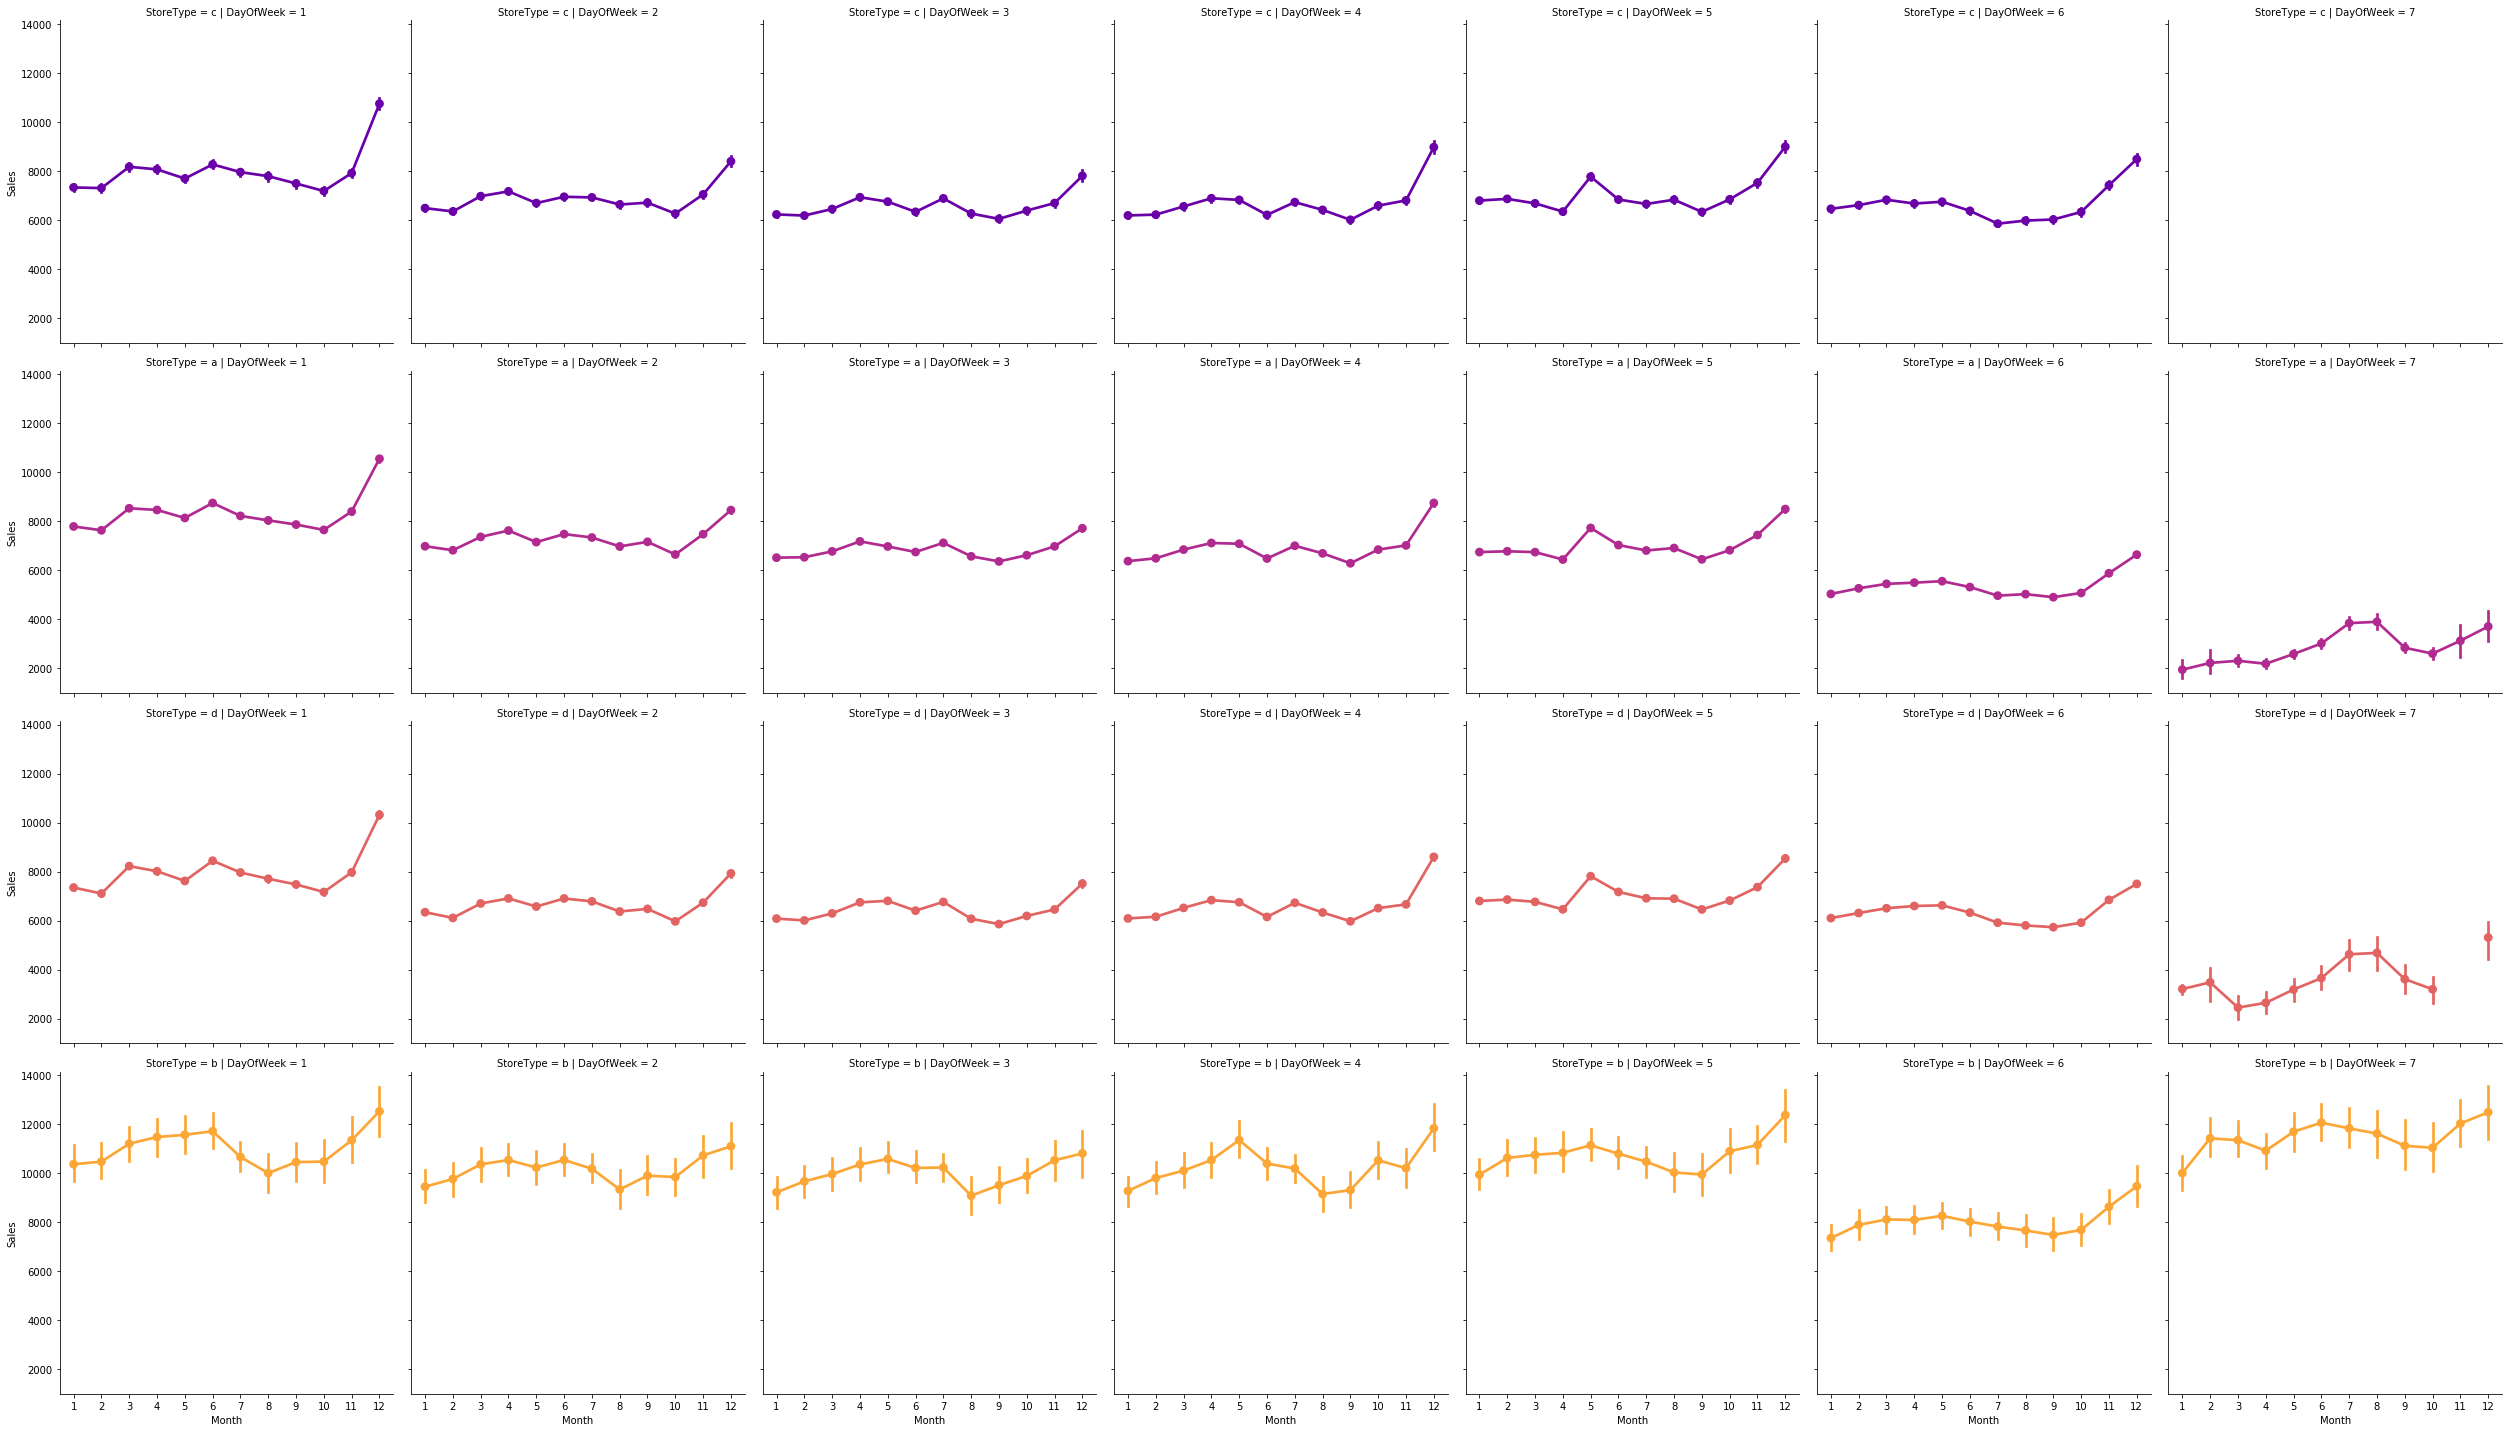

In [77]:
sns.factorplot(data = store_train, x = 'Month', y = "Sales",col='DayOfWeek',hue='StoreType',palette='plasma',
               row='StoreType',color='r')

we can see that stores of type 'c' are closed on Sunday. On the oyher hand other stores are open most of the time. But we can find that stores of type 'd' are closed on sunday from October to December.

Now we will find out which stores are open on Sunday.

In [21]:
store_train[(store_train.Open == 1) & (store_train.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

We can add variables describing the period of time during which competition and promotion were opened:

In [22]:
# competition open time (in months)
store_train['CompetitionOpen'] = 12 * (store_train.Year - store_train.CompetitionOpenSinceYear) + \
        (store_train.Month - store_train.CompetitionOpenSinceMonth)
    
# Promo open time
store_train['PromoOpen'] = 12 * (store_train.Year - store_train.Promo2SinceYear) + \
        (store_train.WeekOfYear - store_train.Promo2SinceWeek) / 4.0

# replace NA's by 0
store_train.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
store_train.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


We found that the most selling and crowded StoreType A doesn't seem to be the one the most exposed to competitors. Instead it's a StoreType B, which also has the longest running period of promotion.

### 6. Correlation Analysis<a class="anchor" id="6-bullet"></a>

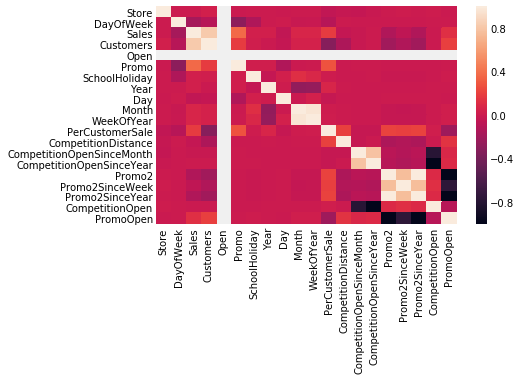

In [23]:
sns.heatmap(store_train.corr())

### 7. Time-Series Analysis<a class="anchor" id="7-bullet"></a>

In [4]:
y = df_train['Sales'].resample('MS').mean()

In [5]:
y['2013':]

Date
2013-01-01    5211.555578
2013-02-01    5494.371397
2013-03-01    5820.349168
2013-04-01    5483.749836
2013-05-01    5364.127383
2013-06-01    5402.162960
2013-07-01    6042.062260
2013-08-01    5729.574049
2013-09-01    5322.988430
2013-10-01    5429.258788
2013-11-01    5864.601614
2013-12-01    6703.618140
2014-01-01    5431.875799
2014-02-01    5731.091512
2014-03-01    5584.257312
2014-04-01    5815.993333
2014-05-01    5632.670534
2014-06-01    5681.526188
2014-07-01    5999.403381
2014-08-01    5649.421252
2014-09-01    5865.104029
2014-10-01    5665.564878
2014-11-01    6179.249661
2014-12-01    6973.282456
2015-01-01    5752.747866
2015-02-01    5710.296541
2015-03-01    5949.130132
2015-04-01    5916.857578
2015-05-01    5472.122002
2015-06-01    6199.203976
2015-07-01    6142.705511
Freq: MS, Name: Sales, dtype: float64

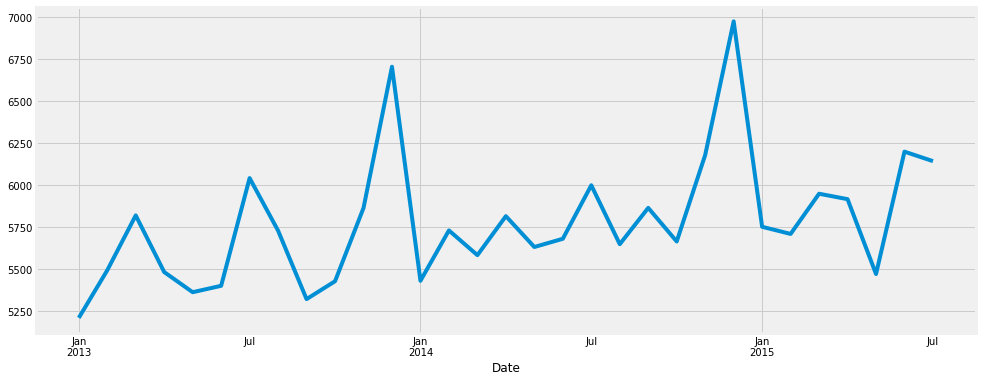

In [40]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

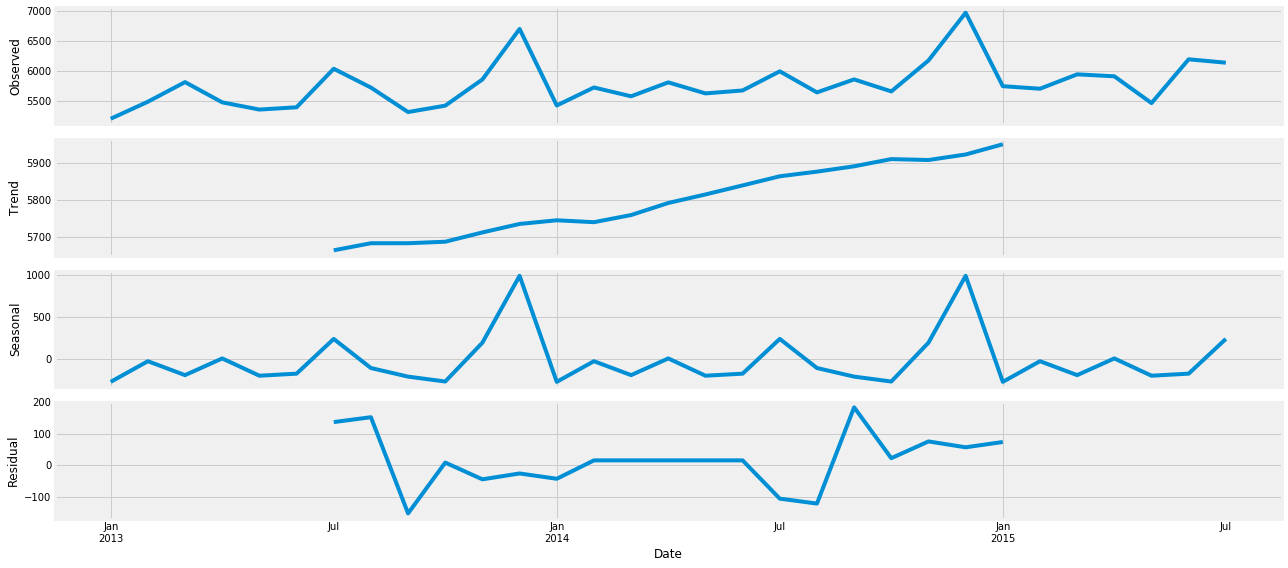

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Now We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### 8. Time series forecasting with ARIMA<a class="anchor" id="8-bullet"></a>

In [6]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Above step is parameter Selection for our Stor’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [7]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:607.1972573203732
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:256.5833039321721
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:261.44641015417045
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:102.54941909448115
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:100.79913454995335
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:569.0222680797169
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:243.9995457980864
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:258.5654839482514
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:102.20029589005479
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:97.7890435207999
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:444.1969282514699
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:249.96398144759596
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:262.42130213651257
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:92.83987032648699
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:93.59020937653708
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:417.1568191753623
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:220.78414481479916
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:253.58983608901013
ARI

### 8.1 Fitting ARIMA Model<a class="anchor" id="8.1-bullet"></a>

In [8]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(3, 0, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5968      0.000  -1395.666      0.000      -0.598      -0.596
ar.L2         -0.8976      0.000  -1816.841      0.000      -0.899      -0.897
ar.L3         -0.1258      0.000   -253.546      0.000      -0.127      -0.125
ar.S.L12       0.7890      0.000   2641.317      0.000       0.788       0.790
sigma2         0.0298   5.86e-06   5086.832      0.000       0.030       0.030


ValueError: operands could not be broadcast together with shapes (9,) (2,) (9,) 

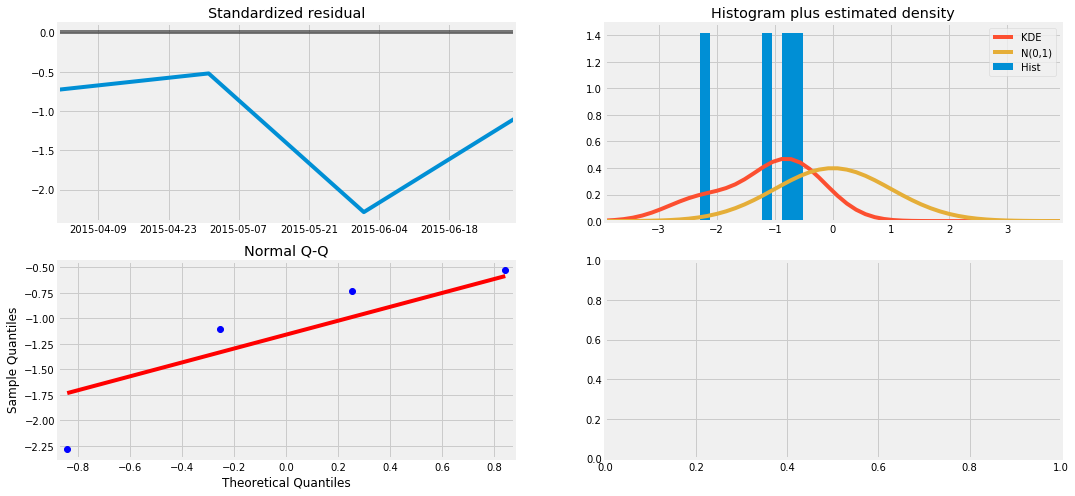

In [13]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

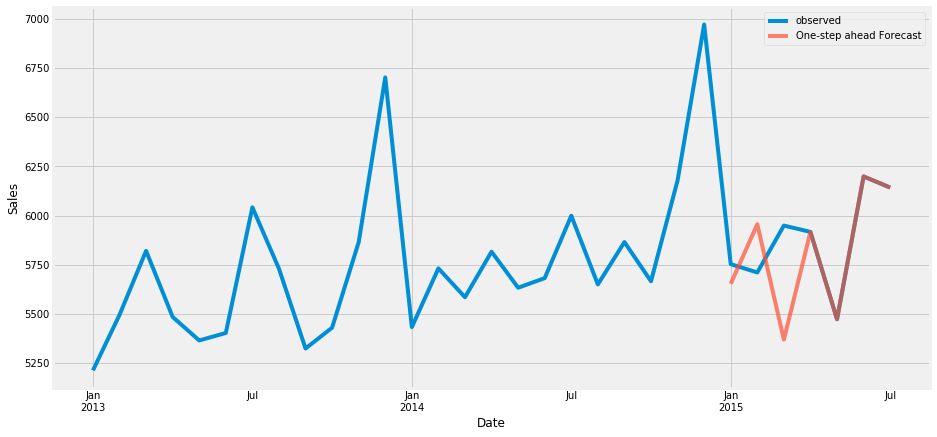

In [9]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
#ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0:],pred_ci.iloc[:, 1:], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [10]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-07-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 58236.69


In [11]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 241.32


### 8.2 Forecaring with ARIMA Model<a class="anchor" id="8.2-bullet"></a>

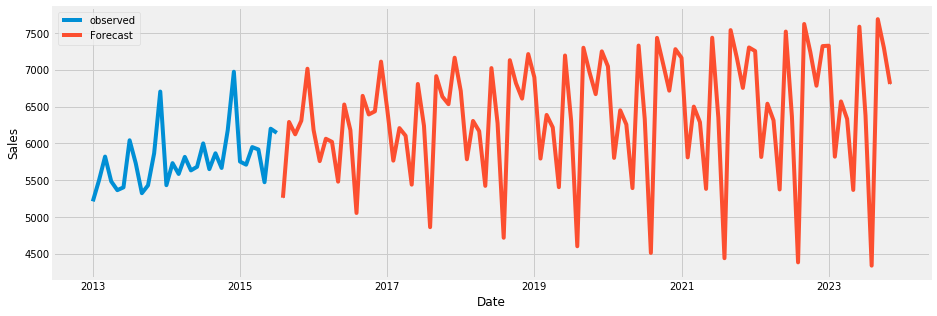

In [13]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

### 9.Conclusion<a class="anchor" id="9-bullet"></a>

RMSE let us know that our model was able to forecast the average daily sales in the test set within 241.32 of the real sales. Our furniture daily sales range from around 708 to over 32547. In my opinion, this is a pretty good model so far. But we will compare this model to regression models using time factor analysis and find out what is the impact of time factor in our regression models.

## License

MIT License

Copyright (c) 2018 pratikkadi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.